In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
from scipy import stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import pickle
import csv

In [2]:
rlist = []
records = os.path.normpath('mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [28]:
subject_dfs = {}
for record in tqdm(rlist):
    subject_dfs[record] = pd.read_csv(os.path.normpath('mit-bih-extracted/'+record+'_full.csv'), index_col=[0,1])

100%|███████████████████████████████████████████| 23/23 [00:01<00:00, 11.93it/s]


In [29]:
subject_dfs['08378'].head()

,,rr_int,rr_int_seconds,rhythms,rmean,rmean_seconds,drmean
,timestamp,,,,,,
0,0.000,208,0.832,N,208.000000,0.832000,0.000000
1,0.788,197,0.788,N,205.250000,0.821000,-2.750000
2,1.576,197,0.788,N,203.187500,0.812750,-2.062500
3,2.372,199,0.796,N,202.140625,0.808562,-1.046875
4,3.168,199,0.796,N,201.355469,0.805422,-0.785156


In [9]:
def extract_rrv(subjdf):
    rrvs = []
    prev_rr_int = 0
    for idx, row in enumerate(subjdf.itertuples()):
        if idx==0:
            rrvs.append(0)
        else:
            rrvs.append(abs(row.rr_int-prev_rr_int)/row.rmean)
        prev_rr_int = row.rr_int
    
    return rrvs

In [30]:
for record in tqdm(rlist):
    subject_dfs[record].rename(columns = {'rhythms':'rhythmLabel'}, inplace = True)

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 2067.44it/s]


In [31]:
for record in tqdm(rlist):
    subject_dfs[record]['rr_variance'] = extract_rrv(subject_dfs[record])

100%|███████████████████████████████████████████| 23/23 [00:02<00:00,  7.83it/s]


In [32]:
subject_dfs['04015'].head()

,,rr_int,rr_int_seconds,rhythmLabel,rmean,rmean_seconds,drmean,rr_variance
,timestamp,,,,,,,
0,0.000,139,0.556,N,139.000000,0.556000,0.000000,0.000000
1,0.632,158,0.632,N,143.750000,0.575000,4.750000,0.132174
2,1.536,226,0.904,N,164.312500,0.657250,20.562500,0.413846
3,2.116,145,0.580,N,159.484375,0.637938,-4.828125,0.507887
4,2.692,144,0.576,N,155.613281,0.622453,-3.871094,0.006426


In [60]:
def plot_time_plot(data, selection, column, nrows, ncols, title, xlabel, ylabel):
    plt.figure(figsize=(28, 16), constrained_layout=True)
    
    for idx, record in enumerate(selection):
        ax = plt.subplot(nrows, ncols, idx + 1)
        ax.set_title('Subject '+str(record), fontsize=28)
        ax.set_xlabel(xlabel, fontsize=24)
        ax.set_ylabel(ylabel, fontsize=24)
        ax.tick_params(labelsize=22)

        df = data[record]

        current = df['rhythmLabel'].iloc[0]
        lastidx = 0
        print("Plot "+str(idx+1)+", Subject "+str(record))
        for row in tqdm(df.itertuples()):
            pos = row.Index[0]
            if pos == len(df)-1:
                dataset=df.loc[lastidx:pos+1]
                if current == 'N':
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='darkcyan')
                elif current == 'A':
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='orange')
                else:
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='salmon')
            elif row.rhythmLabel == current:
                continue
            else:
                dataset=df.loc[lastidx:pos]
                if current == 'N':
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='darkcyan')
                elif current == 'A':
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='orange')
                else:
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='salmon')
                lastidx = pos
                current = row.rhythmLabel
        ax.axhline(y=df[df['rhythmLabel'] == 'N'][column].mean(), color="darkslategray", linestyle="--", linewidth=5)
        ax.axhline(y=df[df['rhythmLabel'] == 'A'][column].mean(), color="purple", linestyle="--", linewidth=5)
        ax.axhline(y=df[df['rhythmLabel'] == 'O'][column].mean(), color="darkred", linestyle="--", linewidth=5)

    plt.suptitle(title, fontsize=36)

    normal_patch = mpatches.Patch(color='darkcyan', label='Normal')
    afib_patch = mpatches.Patch(color='orange', label='Afib')
    other_patch = mpatches.Patch(color='salmon', label='Other')
    normal_mean_patch = mpatches.Patch(color='darkslategray', label='Normal mean')
    afib_mean_patch = mpatches.Patch(color='purple', label='Afib mean')
    other_mean_patch = mpatches.Patch(color='darkred', label='Other mean') 
    plt.figlegend(handles=[normal_patch, afib_patch, other_patch, normal_mean_patch, afib_mean_patch, other_mean_patch], 
                #['Normal', 'Afib', 'Other', 'Normal mean', 'Afib mean', 'Other mean'],
                fontsize=28, 
                loc = "upper right",
                ncol=2,
                shadow = True)

Plot 1, Subject 04746


47865it [00:00, 68539.15it/s]


Plot 2, Subject 04936


53589it [00:02, 20416.94it/s]


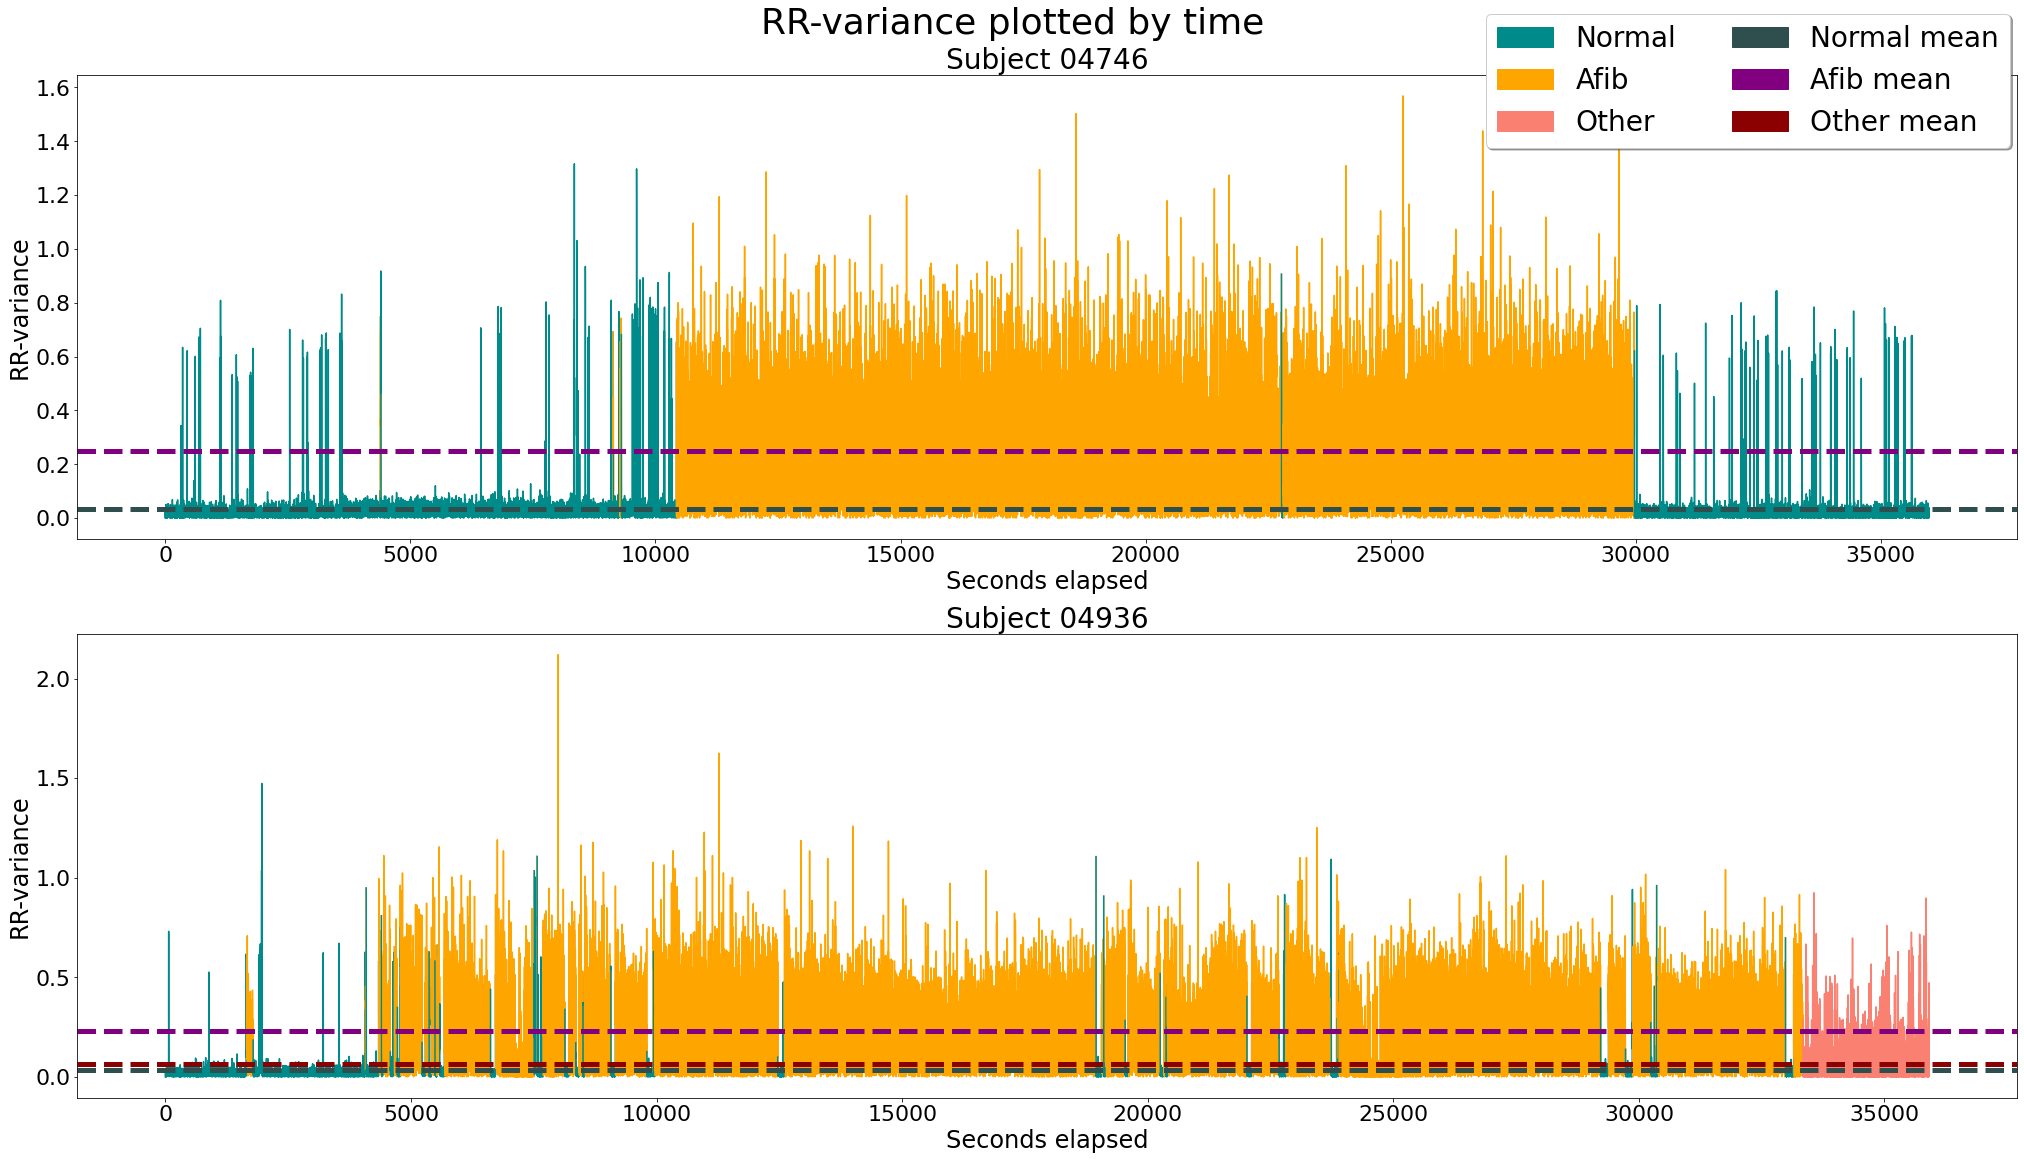

In [61]:
plot_time_plot(subject_dfs, ['04746', '04936'], 'rr_variance', 2, 1, 'RR-variance plotted by time', 'Seconds elapsed', 'RR-variance')

In [47]:
for record in tqdm(rlist):
    subject_dfs[record].to_csv("mit-bih-extracted/"+record+"_full.csv")

100%|███████████████████████████████████████████| 23/23 [00:19<00:00,  1.16it/s]
